# Tumor Segmentation with IOU Loss

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from skimage.transform import resize
from skimage.io import imread

# Import utils
from utils import (
    iou_loss,
    compute_or_load_iou_matrix,
    compute_or_load_prediction_rate,
    apply_erm_iou_control,
    estimate_beta_erm
)

!pip install --upgrade pip -q
!pip install -U --no-cache-dir gdown --pre -q

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
    
data = np.load('../data/polyps/polyps-pranet.npz')
example_paths = os.listdir('../data/polyps/examples')

sgmd = data['sgmd']  # sigmoid scores
gt_masks = data['targets']
example_indexes = data['example_indexes']

print(f"Dataset shape: {sgmd.shape}")
print(f"Number of images: {len(sgmd)}")
print(f"Image size: {sgmd.shape[1]} x {sgmd.shape[2]}")

Dataset shape: (1798, 352, 352)
Number of images: 1798
Image size: 352 x 352


In [3]:
# Problem setup
n = 500  # number of calibration points
lam = 0.01  # regularization parameter

# Debug mode: Set to True for faster debugging, False for full experiments
DEBUG_MODE = True

if DEBUG_MODE:
    theta_grid = np.linspace(0, 1, 50)
    n_replicates = 10
    thetas_viz = np.linspace(0, 1, 50)
    n_bootstrap_beta = 50
else:
    theta_grid = np.linspace(0, 1, 1000)
    n_replicates = 100
    thetas_viz = np.linspace(0, 1, 200)
    n_bootstrap_beta = 100

print(f"Calibration size: {n}")
print(f"Regularization λ: {lam}")
print(f"Number of replicates: {n_replicates}")
print(f"Bootstrap samples for β: {n_bootstrap_beta}")
print(f"Theta grid size: {len(theta_grid)}")

Calibration size: 500
Regularization λ: 0.01
Number of replicates: 10
Bootstrap samples for β: 50
Theta grid size: 50


In [4]:
# Precompute IOU matrix for ALL data (before any splitting)
iou_matrix_full = compute_or_load_iou_matrix(sgmd, gt_masks, theta_grid, verbose=True)
prediction_rate_full = compute_or_load_prediction_rate(sgmd, theta_grid)

print(f"\nIOU matrix shape: {iou_matrix_full.shape}")
print(f"Mean IOU loss across all thetas: {iou_matrix_full.mean():.4f}")
print(f"Best possible IOU loss: {iou_matrix_full.min(axis=1).mean():.4f}")

Loaded IOU matrix from cache: 1798 images x 50 thetas

IOU matrix shape: (1798, 50)
Mean IOU loss across all thetas: 0.4850
Best possible IOU loss: 0.1430


In [5]:
# Split into calibration and validation sets
idx = np.array([1] * n + [0] * (sgmd.shape[0]-n)) > 0
np.random.shuffle(idx)

# Extract calibration and validation data
X_scores_cal, Y_masks_cal = sgmd[idx], gt_masks[idx]
X_scores_val, Y_masks_val = sgmd[~idx], gt_masks[~idx]

iou_matrix_cal = iou_matrix_full[idx, :]
iou_matrix_val = iou_matrix_full[~idx, :]
prediction_rate_cal = prediction_rate_full[idx, :]
prediction_rate_val = prediction_rate_full[~idx, :]

print(f"Calibration set size: {len(X_scores_cal)}")
print(f"Validation set size: {len(X_scores_val)}")

Calibration set size: 500
Validation set size: 1298


In [6]:
# Apply discretized ERM
print("Fitting discretized regularized ERM...")
start_time = time.time()

results_erm = apply_erm_iou_control(
    iou_matrix_cal,
    iou_matrix_val,
    prediction_rate_val,
    theta_grid,
    lam=lam,
    verbose=True
)

elapsed = time.time() - start_time
print(f"\nOptimization completed in {elapsed:.2f}s")
print(f"\nOptimal threshold: θ̂ = {results_erm['theta_hat']:.4f}")
print(f"Validation IOU: {results_erm['empirical_iou']:.4f}")
print(f"Validation IOU Loss: {results_erm['empirical_iou_loss']:.4f}")
print(f"Prediction rate: {results_erm['prediction_rate']:.4f}")

Fitting discretized regularized ERM...
ERM: θ̂=0.4898, IOU Loss=0.1721, pred_rate=0.1139

Optimization completed in 0.00s

Optimal threshold: θ̂ = 0.4898
Validation IOU: 0.8279
Validation IOU Loss: 0.1721
Prediction rate: 0.1139


In [7]:
print("Estimating stability parameter β...")
start_time = time.time()

beta_hat = 0.000111 # With 50 bootstrap samples, the estimate is 0.000111
#beta_hat = estimate_beta_erm(
#    iou_matrix_cal,
#    theta_grid,
#    lam=lam,
#    n_bootstrap=n_bootstrap_beta,
#    method='definition'
#)

elapsed = time.time() - start_time
print(f"\nEstimation completed in {elapsed:.2f}s")
print(f"Estimated β: {beta_hat:.6f}")

Estimating stability parameter β...

Estimation completed in 0.00s
Estimated β: 0.000111


In [8]:
# Compute IOU loss curve for visualization
iou_loss_curve = []
prediction_rate_curve = []

for theta in thetas_viz:
    idx_theta = np.argmin(np.abs(theta_grid - theta))
    iou_loss_val = iou_matrix_val.mean(axis=0)[idx_theta]
    pred_rate = prediction_rate_val.mean(axis=0)[idx_theta]
    iou_loss_curve.append(iou_loss_val)
    prediction_rate_curve.append(pred_rate)

iou_loss_curve = np.array(iou_loss_curve)
prediction_rate_curve = np.array(prediction_rate_curve)

In [9]:
results_experiment = {
    'erm_iou': [],
    'erm_iou_loss': [],
    'erm_pred_rate': [],
    'erm_threshold': [],
    'beta': []
}

print(f"Running {n_replicates} replicates...")
start_time_exp = time.time()

for rep in range(n_replicates):
    if (rep + 1) % max(1, n_replicates // 5) == 0:
        print(f"  Replicate {rep + 1}/{n_replicates}...")
    
    # Random split
    idx_rep = np.array([1] * n + [0] * (sgmd.shape[0] - n)) > 0
    np.random.shuffle(idx_rep)
    
    # Index into cached matrices
    iou_matrix_cal_rep = iou_matrix_full[idx_rep, :]
    iou_matrix_val_rep = iou_matrix_full[~idx_rep, :]
    prediction_rate_val_rep = prediction_rate_full[~idx_rep, :]
    
    # Apply ERM
    res_erm = apply_erm_iou_control(
        iou_matrix_cal_rep,
        iou_matrix_val_rep,
        prediction_rate_val_rep,
        theta_grid,
        lam=lam,
        verbose=False
    )
    
    results_experiment['erm_iou'].append(res_erm['empirical_iou'])
    results_experiment['erm_iou_loss'].append(res_erm['empirical_iou_loss'])
    results_experiment['erm_pred_rate'].append(res_erm['prediction_rate'])
    results_experiment['erm_threshold'].append(res_erm['theta_hat'])
    
    # Use cached beta from earlier
    results_experiment['beta'].append(beta_hat)

# Convert to arrays
for key in results_experiment:
    results_experiment[key] = np.array(results_experiment[key])

elapsed_exp = time.time() - start_time_exp
print(f"\nCompleted {n_replicates} replicates in {elapsed_exp:.2f}s ({elapsed_exp/n_replicates:.3f}s per replicate)\n")

# Summary statistics
print("="*85)
print("RESULTS SUMMARY")
print("="*85)
print(f"{'Metric':<40} {'Mean':<15} {'Std':<15}")
print("-"*85)
print(f"{'Threshold θ̂':<40} {results_experiment['erm_threshold'].mean():<15.4f} {results_experiment['erm_threshold'].std():<15.4f}")
print(f"{'IOU (higher is better)':<40} {results_experiment['erm_iou'].mean():<15.4f} {results_experiment['erm_iou'].std():<15.4f}")
print(f"{'IOU Loss (lower is better)':<40} {results_experiment['erm_iou_loss'].mean():<15.4f} {results_experiment['erm_iou_loss'].std():<15.4f}")
print(f"{'Prediction Rate':<40} {results_experiment['erm_pred_rate'].mean():<15.4f} {results_experiment['erm_pred_rate'].std():<15.4f}")
print(f"{'Stability β':<40} {results_experiment['beta'].mean():<15.6f} {results_experiment['beta'].std():<15.6f}")
print("="*85)

Running 10 replicates...
  Replicate 2/10...
  Replicate 4/10...
  Replicate 6/10...
  Replicate 8/10...
  Replicate 10/10...

Completed 10 replicates in 0.01s (0.001s per replicate)

RESULTS SUMMARY
Metric                                   Mean            Std            
-------------------------------------------------------------------------------------
Threshold θ̂                             0.4939          0.0082         
IOU (higher is better)                   0.8293          0.0046         
IOU Loss (lower is better)               0.1707          0.0046         
Prediction Rate                          0.1147          0.0013         
Stability β                              0.000111        0.000000       


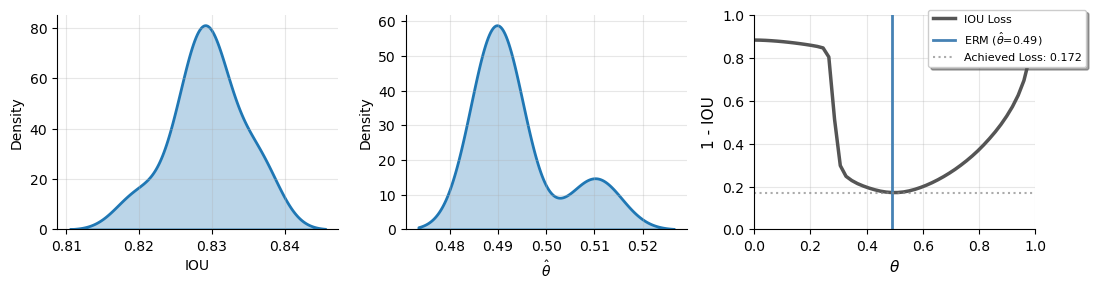

Master figure saved to ./plots/master-figure-iou-segmentation.pdf


In [69]:
# Master figure for paper
fig, axes = plt.subplots(1, 3, figsize=(11, 3))

# Left: IOU KDE
ax_iou_kde = axes[0]
sns.kdeplot(results_experiment['erm_iou'], ax=ax_iou_kde, 
            linewidth=2, fill=True, alpha=0.3)
ax_iou_kde.set_xlabel('IOU', fontsize=10)
ax_iou_kde.set_ylabel('Density', fontsize=10)
ax_iou_kde.grid(True, alpha=0.3)
sns.despine(ax=ax_iou_kde)

# Middle: Threshold KDE
ax_thresh_kde = axes[1]
sns.kdeplot(results_experiment['erm_threshold'], ax=ax_thresh_kde,
            linewidth=2, fill=True, alpha=0.3)
ax_thresh_kde.set_xlabel('$\\hat{\\theta}$', fontsize=10)
ax_thresh_kde.set_ylabel('Density', fontsize=10)
ax_thresh_kde.grid(True, alpha=0.3)
sns.despine(ax=ax_thresh_kde)

# Right: IOU Loss curve
ax_iou = axes[2]
ax_iou.plot(thetas_viz, iou_loss_curve, label='IOU Loss', linewidth=2.5, color='#555555')
ax_iou.axvline(x=results_erm['theta_hat'], linewidth=2, linestyle='-', 
               label=f"ERM ($\\hat{{\\theta}}$={results_erm['theta_hat']:.2f})", color='#4682B4')
ax_iou.axhline(y=results_erm['empirical_iou_loss'], linewidth=1.5, linestyle=':', 
               label=f"Achieved Loss: {results_erm['empirical_iou_loss']:.3f}", color='#888888', alpha=0.7)
ax_iou.set_xlabel('$\\theta$', fontsize=11)
ax_iou.set_ylabel('1 - IOU', fontsize=11)
ax_iou.legend(fontsize=8, loc='upper right', bbox_to_anchor=(1.2, 1.05), frameon=True, shadow=True)
ax_iou.set_xlim([0, 1])
ax_iou.set_ylim([0, min(1.0, iou_loss_curve.max() * 1.1)])
ax_iou.grid(True, alpha=0.3)
sns.despine(ax=ax_iou)

plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig('./plots/master-figure-iou-segmentation.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Master figure saved to ./plots/master-figure-iou-segmentation.pdf")